# Assignment1 - Bird Species - Classification - Part 2

# Imports

In [1]:
import os
import torch
from torchvision import datasets
import numpy as np

import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.transforms.functional as transform
from torchvision.io import read_image
from torchsummary import summary
#from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import glob

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cpu')

# Data preparation

In [4]:
# data_dir = '/Users/Public/Documents/'
data_dir = '/workspace'
train_dir = os.path.join(data_dir,'train')
valid_dir = os.path.join(data_dir,'valid')
test_dir = os.path.join(data_dir,'test')
mf = data_dir + "/birds.csv"
df = pd.read_csv(data_dir + "/birds.csv")
input_shape = (224, 224, 3)   # (img_width, img_height, n_chanel)

seed = 2020
torch.manual_seed(seed)
if(torch.has_cuda) :
    device = torch.device('cuda')
print(device)

cuda


**Methods**

In [5]:
def show_batch(data_loader):
# obtain one batch of training images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(15,5))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(labels[idx])

In [6]:
def create_dataloader(data, batch_s, sampler, workrs=0):
    return DataLoader(
        dataset = data, 
        batch_size = batch_s,
        sampler = sampler,
        num_workers = workrs    
    )

In [58]:
def plot_history(history):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(history['train_acc'])
    ax[0].plot(history['valid_acc'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('10-Epochs for 1-Fold')
    ax[0].legend(['Train', 'Valid'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history['train_loss'])
    ax[1].plot(history['valid_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Valid'], loc='upper left')
    plt.show()

# Sample

**Function responsible for reading the images**

In [8]:
def read_images_from_directory(directory, input_shape) :
    from PIL import Image
    # Database reading
    classes = glob.glob(directory +'/train/*') ## Array containing the directory of each class
    # print(classes)
    X = []
    y = []
    labels = []
    for i in range(len(classes)): ## For each directory, reads all images
        files = glob.glob (classes[i] + "/*") 
        for myFile in files: 
            im = Image.open(myFile)
            im = np.array(im)
            X.append(im)
            y.append(classes[i] .split('/')[-1])  ## Array containing class labels
            labels.append(myFile.split('/')[-1].split('.')[0])
  
    del directory, classes, i, files, myFile, im ## Remove variables that will no longer be used
    
    return np.asarray(X), np.asarray(y), np.asarray(labels)


In [9]:
n, m, z = read_images_from_directory(data_dir, 4) ## n = array by RGB for all images, m = arrat class labels, z = array for pathdirectory to images
#run a lot of time

**Creating a path to data files and describing the files**

In [10]:
test_images = glob.glob(data_dir+'/images to test/*')
train = glob.glob(train_dir+'/*/*')
test = glob.glob(test_dir+'/*/*')
valid  = glob.glob(valid_dir+'/*/*')
classes = glob.glob(train_dir+'/*')
print(f'Train set size: {len(train)}\nTest set size: {len(test)}\nValidation set size: {len(valid)}\nTotal number of classes: {len(classes)}' )

Train set size: 70626
Test set size: 2250
Validation set size: 2250
Total number of classes: 450


# Create data transforms & dataloader

In [11]:
# Data augmentation is a good practice for the train set, after we saw in part1 that there is some classes that have small amount of training samples
# Here, we can do some transformation. we start with part of them:
# crop images to 224x224, random rotation of 20+- degrees for training set 

data_transforms_train = transforms.Compose([
        # transforms.ToPILImage(), ## For it can be display as image to see transformation
        transforms.CenterCrop(224),
        transforms.RandomRotation(20), 
        transforms.ToTensor()
    ])

data_transforms_other = transforms.Compose([
        # transforms.ToPILImage(), 
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

**Create Dataset**

In [12]:
## to check

class_dict = {}
classes_1 = os.listdir(data_dir + '/train')
#Creating a dictionary of the classes and their corresponding img count
for class_name in classes_1:
    try:
        temp_path = os.path.join(train_dir, class_name)
        class_dict[class_name] = len(os.listdir(temp_path))
    except:
        pass
#Creating a dataframe of the classes and their corresponding img count
classes = pd.DataFrame(class_dict.items(), columns = ['class_name', 'count'])

In [14]:
# Creating a list of all images 
train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes_1:
    for img in os.listdir(data_dir + "/train/" + _class):
        train_imgs.append(data_dir +"/train/"+ _class + "/" + img)
    
    for img in os.listdir(data_dir + "/valid/" + _class):
        valid_imgs.append(data_dir + "/valid/" + _class + "/" + img)
        
    for img in os.listdir(data_dir  + "/test/" + _class):
        test_imgs.append(data_dir + "/test/" + _class + "/" + img)

# Make dictonary
# class_to_int = {classes[i] : i for i in range(len(classes_1))}

In [443]:
class Birds_dataset(Dataset):
    def __init__(self, imgs_list, class_to_int, transforms = None):
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
        image_path = self.imgs_list[index]
        
        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Retriving class label
        label = image_path.split("/")[-2]
        # label = self.class_to_int[label]
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        return image, label
        
    def __len__(self):
        return len(self.imgs_list)

In [439]:
aa = train_imgs[1]
dfss = aa.split("/")[-2]
dfss

'ABBOTTS BABBLER'

In [452]:
set = Birds_dataset(train_imgs, 1, data_transforms_train)

In [390]:
class Birdi_dataset(Dataset):    
    def __init__(self,path_to_imgs,labels_file,transform=None,trarget_transform=None):
        # labels_file contains filename and label for that file
        # type equal to type of data set
        self.labels = pd.read_csv(labels_file)
        self.path_to_imgs = path_to_imgs
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        path_to_imgs = os.path.join(self.path_to_imgs,self.labels.iloc[idx,1]) ##
        image = read_image(path_to_imgs)
        # print(type(image))
        label = self.labels.iloc[idx,2]
        if self.transform:
            image = self.transform(image)
        return image, label

In [424]:
class Bird_dataset(Dataset):    
    def __init__(self,path_to_imgs,labels_file,type,transform=None,trarget_transform=None):
        # labels_file contains filename and label for that file
        # type equal to type of data set
        self.labels = labels_file.loc[labels_file['data set'].isin([type.format()])]
        self.path_to_imgs = path_to_imgs
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        path_to_imgs = os.path.join(self.path_to_imgs,self.labels.iloc[idx,1]) ##
        image = read_image(path_to_imgs)
        label = self.labels.iloc[idx,2]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [15]:
# train_data = Birdi_dataset(data_dir, mf)#, transform=data_transforms_train)
# valid_data = Bird_dataset(data_dir, df, 'valid', transform=data_transforms_other)
# test_data = Bird_dataset(data_dir, df, 'test', transform=data_transforms_other)

#Setting the corrosponding labels with their classes
train_image_folder = datasets.ImageFolder(data_dir + "/train", transform=data_transforms_train)
valid_image_folder = datasets.ImageFolder(data_dir + "/valid", transform=data_transforms_other)
test_image_folder = datasets.ImageFolder(data_dir + "/test", transform=data_transforms_other)
idx_to_class = {v: k for k, v in train_image_folder.class_to_idx.items()}

**Create DataLoader**

In [312]:
sampler_train = RandomSampler(train_image_folder)
sampler_valid = RandomSampler(valid_data)
sampler_test = RandomSampler(test_data)

print(sampler_train.num_samples)

# batch_size = 20
# #Shuffle Argument is mutually exclusive with Sampler!
# train_data_loader = create_dataloader(train_data, batch_size, sampler_train)
# valid_data_loader = create_dataloader(valid_data, batch_size, sampler_valid)
# test_data_loader = create_dataloader(test_data, batch_size, sampler_test)

70626


# Create Model 1

In [16]:
class BirdModel(nn.Module):
    def __init__(self):
        super(BirdModel,self).__init__()
        # convolutional layer (3x224x224)
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1) # add last
        # convolutional layer (6x224x224)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=0)
        # convolutional layer (16x222x222)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=0)
        # convolutional layer (32x220x220)
        self.conv4 = nn.Conv2d(32, 64, 5, padding=0)
        # output tensor size is 64x216x216
        # max pooling layer
        self.pool = nn.MaxPool2d(4, 4)
        # output tensor size is 64x54x54
        # linear layer (64 * 54 * 54 -> 1000) (+kernal)
        self.fc1 = nn.Linear(64 * 54 * 54, 1000)
        # linear layer (2000 -> 450)
        self.fc2 = nn.Linear(1000, 450)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x)) # add last
        x = self.pool(x)
        # flatten image input
        x = x.view(-1, 64 * 54 * 54)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = self.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

In [17]:
def train_loop(data_loader,model,device,loss_fn,optimizer,print_every_n=500):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    tp=0
    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(dtype=torch.long)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)
        train_loss += loss
        tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%print_every_n==0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss={loss:.3f}, {current} samples / {size}')

        
        
    train_loss /= num_batches
    train_acc = tp/size    
        
    return train_loss,train_acc

def valid_loop(data_loader,model,device,loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    valid_loss=0
    tp=0
    with torch.no_grad():
        for images,Labels in data_loader:
            images = images.to(device)
            Labels = Labels.to(dtype=torch.long)
            Labels = Labels.to(device)
            pred = model(images)
            valid_loss += loss_fn(pred,Labels).item()
            tp += (Labels==pred.argmax(1)).type(torch.float).sum().item()
        
    valid_loss /= num_batches
    valid_acc = tp/size
    print(f'accuracy = {valid_acc}, valid_loss = {valid_loss:2f}')
    return valid_loss,valid_acc  

In [18]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

**Implement K-fold**

*Divide the data into K folds in order to keep the balance of the original data set*

In [19]:
from torchsummary import summary
K = 5 # number of folds for cross validation
skf = StratifiedKFold(n_splits = K, shuffle=True)
# skf = KFold(n_splits=5)
batch_size = 20
learning_rate = 1e-3
epochs = 10
loss_fn = nn.CrossEntropyLoss()

In [21]:
xs = df.filepaths
ys = df.labels
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, shuffle=True)

In [22]:
history = {'train_loss': [], 'valid_loss': [],'train_acc':[],'valid_acc':[]}

for fold, (train_idx,val_idx) in enumerate(skf.split(xs,ys)):

    print('Fold {}'.format(fold + 1))

    sampler_train = RandomSampler(train_idx)
    sampler_valid = RandomSampler(val_idx)
    train_loader = create_dataloader(train_image_folder, batch_size, sampler_train)
    valid_loader = create_dataloader(train_image_folder, batch_size, sampler_valid)
    
    model = BirdModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

    for epoch in range(epochs):
        train_loss, train_correct = train_loop(train_loader,model,device,loss_fn,optimizer)
        valid_loss, valid_correct = valid_loop(valid_loader,model,device,loss_fn)

        # train_loss, train_correct = train_epoch(model,device,train_loader,loss_fn,optimizer)
        # valid_loss, valid_correct = valid_epoch(model,device,valid_loader,loss_fn)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        valid_loss = valid_loss / len(valid_loader.sampler)
        valid_acc = valid_correct / len(valid_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Valid Loss:{:.3f} AVG Training Acc {:.2f} % AVG Valid Acc {:.2f} %".format(epoch + 1,
                                                                                                             epochs,
                                                                                                             train_loss,
                                                                                                             valid_loss,
                                                                                                             train_acc,
                                                                                                             valid_acc))
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_acc)
        history['valid_acc'].append(valid_acc)


Fold 1
loss=6.114, 0 samples / 70626
loss=5.900, 10000 samples / 70626
loss=6.001, 20000 samples / 70626
loss=5.925, 30000 samples / 70626
loss=5.915, 40000 samples / 70626
loss=5.955, 50000 samples / 70626
loss=5.901, 60000 samples / 70626
accuracy = 0.0, valid_loss = 5.948339
Epoch:1/10 AVG Training Loss:0.000 AVG Valid Loss:0.000 AVG Training Acc 0.00 % AVG Valid Acc 0.00 %
loss=5.991, 0 samples / 70626
loss=5.933, 10000 samples / 70626
loss=5.939, 20000 samples / 70626
loss=5.960, 30000 samples / 70626
loss=5.939, 40000 samples / 70626
loss=5.953, 50000 samples / 70626
loss=5.911, 60000 samples / 70626
accuracy = 0.0, valid_loss = 5.950970
Epoch:2/10 AVG Training Loss:0.000 AVG Valid Loss:0.000 AVG Training Acc 0.00 % AVG Valid Acc 0.00 %
loss=5.941, 0 samples / 70626
loss=5.939, 10000 samples / 70626
loss=5.926, 20000 samples / 70626
loss=5.931, 30000 samples / 70626
loss=5.902, 40000 samples / 70626
loss=5.949, 50000 samples / 70626
loss=5.976, 60000 samples / 70626
accuracy = 0.

**Calculate the average performances**

In [50]:
avg_train_loss = np.mean(history['train_loss'])
avg_valid_loss = np.mean(history['valid_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_valid_acc = np.mean(history['valid_acc'])

print('Performance of {} fold cross validation'.format(K))
print("Average Training Loss: {:.4f} \t Average Valid Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Valid Acc: {:.3f}".format(avg_train_loss,avg_valid_loss,avg_train_acc,avg_valid_acc))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [51]:
history

{'train_loss': [tensor(9.9345e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(9.9035e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(9.9003e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(9.8982e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(9.8971e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(9.8962e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(9.8955e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(9.8951e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(9.8949e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(9.8949e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(8.7047e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(7.7940e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(7.2999e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(6.7657e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(6.2581e-05, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(5.8594e-05, device='cuda:0', gra

**Need to send tensor to cpu**

In [53]:
if isinstance(history, torch.Tensor):
    history = history.cpu().numpy()

for i, o in enumerate(history):
    if o is not None:
        # sometimes output can be a list of tensor, so here ensure the type again, this fixes the error.
        if isinstance(o, torch.Tensor):
            o = o.cpu().numpy()
        if i == 1:
            train_loss = []
            for loss in history[o]:
                train_loss.append(loss)
        if i == 2:
            valid_loss = []
            for loss in history[o]:
                valid_loss.append(loss)
        if i == 3:
            train_acc = []
            for acc in history[o]:
                train_acc.append(acc)
        if i == 4:
            valid_acc = []
            for acc in history[o]:
                valid_acc.append(acc)

In [54]:
avg_train_loss = np.mean(train_loss)
avg_valid_loss = np.mean(valid_loss)
avg_train_acc = np.mean(train_acc)
avg_valid_acc = np.mean(valid_acc)

print('Performance of {} fold cross validation'.format(K))
print("Average Training Loss: {:.4f} \t Average Valid Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Valid Acc: {:.3f}".format(avg_train_loss,avg_valid_loss,avg_train_acc,avg_valid_acc))

Performance of 5 fold cross validation
Average Training Loss: 0.0004 	 Average Valid Loss: 0.0001 	 Average Training Acc: 0.000 	 Average Valid Acc: 0.000


In [61]:
def plots_history(train_loss, valid_loss, train_acc, valid_acc):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(train_acc)
    ax[0].plot(valid_acc)
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('10-Epochs for 1-Fold')
    ax[0].legend(['Train', 'Valid'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(train_loss)
    ax[1].plot(valid_loss)
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('10-Epochs for 1-Fold')
    ax[1].legend(['Train', 'Valid'], loc='upper left')
    plt.show()

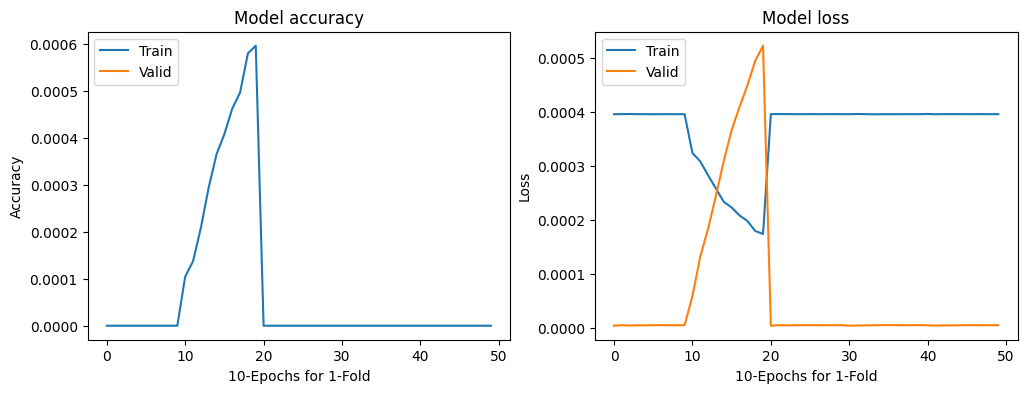

In [62]:
plots_history(train_loss, valid_loss, train_acc, valid_acc)

In [ ]:
history = []
for i in range(epochs):
    print(f'epoch: {i+1}')
    train_loss,train_acc = train_loop(train_data_loader,model,device,loss_fn,optimizer)
    val_loss,val_acc = valid_loop(valid_data_loader,model,device,loss_fn)
    history.append({'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc})
    print('---------------------------')

In [ ]:
history = pd.DataFrame(history)
plot_history(history)

**Transformation**